## Use PRSice for PGS numbers

In [ ]:
Rscript ~/workspaces/admixturemapping/bin/PRSice/PRSice.R \
    --prsice ~/workspaces/admixturemapping/bin/PRSice/PRSice_linux \
    --base Step2/extractedChrAll.SaigeGWAS.tsv \
    --A1 Allele2 \
    --A2 Allele1 \
    --chr CHR \
    --bp POS \
    --stat BETA \
    --pvalue p.value \
    --snp MarkerID \
    --thread 12 \
    --memory 97000 \
    --beta \
    --binary-target F \
    --target Clumping/extractedChr15.ACAF.QC.PlinkNative \
    --pheno CreatinineCohort.PhenotypeFile.PRSice.tsv \
    --pheno-col MedianCreatinine \
    --ignore-fid

## Perform clumping.

In [ ]:
plink2 --bfile extractedChr15.ACAF.QC.PlinkNative \
    --clump extractedChr15.SaigeGWAS.tsv \
    --clump-p1 1e-5 \
    --clump-p2 1e-2 \
    --clump-r2 0.1 \
    --clump-kb 3000 \
    --chr 15 \
    --out extractedChr15.SaigeGWAS.Clumping \
    --memory 47000

In [ ]:
%%bash

for i in {1..22};
do
    echo "-----------------> Starting with Chr $i <-------------------"

    #Download the exome file from the bucket.
    gsutil -m cp -r \
    gs://fc-secure-83b42338-cb7b-4b00-9eea-27f70958b5ee/Data/Genetic/ACAF.Downsample/extractedChr$i.ACAF.QC.PlinkNative.* \
       Data/Saige.V2/Clumping/ACAF/
    
    plink2 --bfile Data/Saige.V2/Clumping/ACAF/extractedChr$i.ACAF.QC.PlinkNative \
        --clump Data/Saige.V2/Clumping/extractedChrAll.SaigeGWAS.tsv \
        --clump-p1 1e-4 \
        --clump-p2 1e-2 \
        --clump-r2 0.1 \
        --clump-kb 3000 \
        --chr $i \
        --out Data/Saige.V2/Clumping/Results/extractedChr$i.SaigeGWAS.Clumping \
        --threads 8 \
        --memory 55000


    #Remove the exome file.
    rm Data/Saige.V2/Clumping/ACAF/extractedChr$i.ACAF.QC.PlinkNative.*
    
    echo "-----------------> Finished with Chr $i <-------------------"
    
done

## Get AF from GnomAD

In [1]:
import requests
import time
import pandas as pd

In [2]:
snp_ids = pd.read_csv("Data/Saige.V2/PGS/Liability/ACAF/VariantsIDs.ChrAll.Clumping.txt", header=None)
snp_ids['variant'] = snp_ids[0].str.replace(":", "-", regex=False).str.replace("^chr", "", regex=True)

snp_ids = snp_ids["variant"].tolist()

In [8]:
def get_gnomad_allele_frequencies(snp_id, dataset="gnomad_r4"):
    url = "https://gnomad.broadinstitute.org/api"
    print(snp_id)
    # GraphQL Query
    query = """
    {
        variant(variantId: \"""" + snp_id + """\", dataset: gnomad_r4) {
            variantId
            reference_genome
            chrom
            pos
            ref
            alt
            va {
              genome {
                derivedFrom {
                  id
                }
                alleleFrequency
                cohort {
                  id
                }
              }
            }
        }
    }
    """
    headers = {"Content-Type": "application/json"}
    frequencies = {}
    try:
        response = requests.post(url, json={"query": query}, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        for entry in data["data"]["variant"]["va"]["genome"]:
            if entry["derivedFrom"]["id"] == "gnomad4.1.0":  # Ensure the dataset is correct
                cohort_id = entry["cohort"]["id"]
                if cohort_id in ["nfe", "afr"]:  # Extract only "nfe" and "afr"
                    frequencies[cohort_id] = entry["alleleFrequency"]
        
        #Keep API happy.
        time.sleep(1.5)
        return frequencies
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return {'afr': -9, 'nfe': -9}

In [ ]:
# Example usage
allele_frequencies = {}
for snp_id in snp_ids:
    allele_frequencies[snp_id] = get_gnomad_allele_frequencies(snp_id)

In [10]:
# Convert dictionary to a DataFrame
df = pd.DataFrame([(variant, pop, freq) for variant, pop_dict in allele_frequencies.items() for pop, freq in pop_dict.items()], 
                  columns=['MarkerID', 'Population', 'AF'])

# Display the DataFrame
print(df)

# Save to a TSV file (optional)
df.to_csv('Data/Saige.V2/PGS/Liability/AlleleFrequencies.tsv', sep='\t', index=False)


                MarkerID Population        AF
0     1-218502664-C-CTTT        afr  0.229413
1     1-218502664-C-CTTT        nfe  0.107609
2       1-107764075-GA-G        afr  0.815701
3       1-107764075-GA-G        nfe  0.994629
4         1-70379612-A-G        afr  0.023527
...                  ...        ...       ...
1617     22-21026740-G-A        nfe  0.000323
1618     22-17136561-G-A        afr  0.100240
1619     22-17136561-G-A        nfe  0.223242
1620     22-42578139-T-C        afr  0.034451
1621     22-42578139-T-C        nfe  0.000147

[1622 rows x 3 columns]


## Liability PRS calculations.

In [3]:
library(IRdisplay)

display_html('
<style>
  .container {
    width: 80% !important;
  }
</style>
')


In [1]:
options(repr.plot.width=20, repr.plot.height=16)

In [4]:
rm(list=ls())
set.seed(13)

options(scipen=100, digits=3)

library('dplyr')
library('ggplot2')
library('data.table')
library('parallel')
library('stringr')
library('tidyr')

options(repr.plot.width=16, repr.plot.height=10)
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

### Read the clumping results.

In [5]:
#Implement a read function.
fread_df = function(x) {
    return(as.data.frame(fread(x))) 
}

read_clumping_files = function(clumping_result_files) { 
    # Read and store the files in a list
    clumping_files_read = lapply(clumping_result_files, fread_df)

    # Combine the list of data frames into one data frame
    clumping_results = do.call(rbind, clumping_files_read)

    #Reset index.
    rownames(clumping_results) = NULL 
    
    #Write the file with variant ID.
    write.table(x = clumping_results %>% select(ID), file = paste0("Data/Saige.V2/PGS/Liability/ACAF/VariantsIDs.ChrAll.Clumping.txt"),
               sep = "\t", row.names = F, col.names = F, quote = F)
    
    return(clumping_results)
}

clumping_results = read_clumping_files(paste0('Data/Saige.V2/Clumping/Results/extractedChr', 
                                                    c(1:22), 
                                                    '.SaigeGWAS.Clumping.clumps'))

dim(clumping_results)
head(clumping_results %>% arrange(P))

[1] 811  11

#CHROM POS       ID                     P                     TOTAL NONSIG
1 15      45379909 chr15:45379909:C:T     0.0000000000000000228 1138  25    
2 11      30755467 chr11:30755467:G:GA    0.0000000173285000000   90  22    
3 15      45466280 chr15:45466280:A:G     0.0000000187185000000  261  47    
4 10     110813835 chr10:110813835:CAA:C  0.0000001948280000000   30  12    
5 15      31198823 chr15:31198823:T:TTCTC 0.0000002003730000000    0   0    
6  1     218502664 chr1:218502664:C:CTTT  0.0000002288600000000  232  70    
  S0.05 S0.01 S0.001 S0.0001
1 182   436   92     403    
2  45    14    6       3    
3  52    73   52      37    
4   6     6    4       2    
5   0     0    0       0    
6  26    14   16     106    
  SP2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [6]:
clumping_results %>% filter(P < 0.0000001) %>% arrange(P)

#CHROM POS      ID                  P                     TOTAL NONSIG S0.05
1 15     45379909 chr15:45379909:C:T  0.0000000000000000228 1138  25     182  
2 11     30755467 chr11:30755467:G:GA 0.0000000173285000000   90  22      45  
3 15     45466280 chr15:45466280:A:G  0.0000000187185000000  261  47      52  
  S0.01 S0.001 S0.0001
1 436   92     403    
2  14    6       3    
3  73   52      37    
  SP2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [7]:
head(clumping_results) 
tail(clumping_results)

,#CHROM,POS,ID,P,TOTAL,NONSIG,S0.05,S0.01,S0.001,S0.0001,SP2
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,1,218502664,chr1:218502664:C:CTTT,0.000000229,232,70,26,14,16,106,"chr1:218391302:C:T,chr1:218395131:G:A,chr1:218395140:T:A,chr1:218395462:G:A,chr1:218395772:T:C,chr1:218395866:G:A,chr1:218397724:A:G,chr1:218399426:T:G,chr1:218399466:A:G,chr1:218401447:C:T,chr1:218406643:A:G,chr1:218466247:G:T,chr1:218466919:G:C,chr1:218470598:C:T,chr1:218472531:T:G,chr1:218472823:C:CA,chr1:218479648:A:T,chr1:218481165:G:C,chr1:218481392:G:A,chr1:218482944:C:T,chr1:218483045:A:G,chr1:218484446:C:T,chr1:218485016:C:T,chr1:218485034:G:C,chr1:218485842:G:A,chr1:218486682:C:T,chr1:218486935:T:A,chr1:218486990:AC:A,chr1:218489847:A:G,chr1:218491466:C:A,chr1:218493087:A:T,chr1:218496624:T:TAAAA,chr1:218496799:G:C,chr1:218499465:G:A,chr1:218499915:C:T,chr1:218500251:A:T,chr1:218500414:T:TAAATA,chr1:218500473:G:A,chr1:218500660:C:A,chr1:218500894:T:C,chr1:218501255:T:C,chr1:218501289:T:C,chr1:218501533:A:G,chr1:218501588:A:G,chr1:218501704:A:G,chr1:218502063:C:A,chr1:218502176:G:C,chr1:218502242:G:A,chr1:218502891:G:T,chr1:218503102:C:T,chr1:218503341:C:G,chr1:218503508:CT:C,chr1:218503622:A:G,chr1:218503636:T:C,chr1:218503717:T:C,chr1:218504336:TATC:T,chr1:218504461:A:G,chr1:218504957:G:A,chr1:218505281:T:C,chr1:218505359:G:A,chr1:218505742:T:C,chr1:218506004:CT:C,chr1:218506048:A:C,chr1:218506344:G:A,chr1:218506388:C:T,chr1:218507396:C:G,chr1:218507616:A:G,chr1:218507634:A:G,chr1:218507703:T:A,chr1:218507756:C:T,chr1:218507967:T:G,chr1:218508033:C:T,chr1:218508160:G:A,chr1:218508210:G:T,chr1:218508286:GTC:G,chr1:218508773:T:C,chr1:218508777:A:G,chr1:218508919:A:G,chr1:218509485:A:G,chr1:218510075:C:CT,chr1:218510186:A:G,chr1:218510194:A:G,chr1:218510324:T:TTCTC,chr1:218510342:C:T,chr1:218510675:G:A,chr1:218510722:G:GT,chr1:218511498:A:G,chr1:218511504:C:G,chr1:218511508:C:A,chr1:218511713:G:A,chr1:218511718:G:A,chr1:218511789:A:T,chr1:218511946:A:G,chr1:218512033:T:G,chr1:218512054:GT:G,chr1:218512377:T:C,chr1:218512653:T:C,chr1:218513401:G:C,chr1:218513613:G:A,chr1:218513663:A:G,chr1:218514076:A:T,chr1:218514077:T:A,chr1:218514453:A:G,chr1:218515494:A:G,chr1:218515944:G:A,chr1:218516032:T:C,chr1:218516117:G:A,chr1:218517235:G:A,chr1:218517510:C:T,chr1:218517790:T:A,chr1:218517972:C:T,chr1:218518049:AT:A,chr1:218518160:A:T,chr1:218518750:CCA:C,chr1:218519299:C:T,chr1:218520110:C:T,chr1:218520349:T:G,chr1:218520470:C:T,chr1:218520530:A:G,chr1:218521007:C:T,chr1:218521037:CT:C,chr1:218521283:C:T,chr1:218521302:A:G,chr1:218521649:A:T,chr1:218521705:G:A,chr1:218523561:C:T,chr1:218524640:T:A,chr1:218525386:G:A,chr1:218526473:A:G,chr1:218526594:T:C,chr1:218527042:G:T,chr1:218527186:A:T,chr1:218528109:A:G,chr1:218529534:A:G,chr1:218529793:C:T,chr1:218530076:GT:G"
2,1,107764075,chr1:107764075:GA:G,0.000000703,146,23,43,49,18,13,"chr1:107585487:T:C,chr1:107592472:T:C,chr1:107596150:A:T,chr1:107614479:T:TA,chr1:107643530:G:A,chr1:107649571:G:A,chr1:107653552:C:T,chr1:107653780:AT:A,chr1:107654537:G:A,chr1:107657345:A:G,chr1:107657678:C:G,chr1:107662826:T:C,chr1:107722840:C:CTTTTT,chr1:107726363:T:C,chr1:107726414:C:T,chr1:107732796:T:C,chr1:107734550:C:G,chr1:107734551:C:G,chr1:107736355:A:C,chr1:107736762:A:G,chr1:107744349:A:G,chr1:107746033:A:G,chr1:107746272:A:T,chr1:107746882:CT:C,chr1:107747122:T:C,chr1:107749638:A:G,chr1:107750013:G:GTGT,chr1:107751874:G:A,chr1:107754539:C:T,chr1:107756660:G:A,chr1:107757187:G:GTA,chr1:107757352:T:C,chr1:107760353:T:C,chr1:107760550:G:C,chr1:107761254:A:G,chr1:107762256:G:T,chr1:107762379:C:T,chr1:107762532:A:G,chr1:107763923:A:T,chr1:107765105:T:A,chr1:107765969:A:AT,chr1:107767130:G:A,chr1:107768538:T:C,chr1:107772683:C:T,chr1:107774913:CT:C,chr1:107775962:G:A,chr1:107790228:G:A,chr1:107791384:CA:C,chr1:107795910:C:A,chr1:107795949:C:T,chr1:107798437:G:A,chr1:107801368:G:A,chr1:107801883:A:G,chr1:107802634:T:C,chr1:107802887:T:C,chr1:107804504:A:C,chr1:107807530:C:T,chr1:107808678:T:C,chr1

,#CHROM,POS,ID,P,TOTAL,NONSIG,S0.05,S0.01,S0.001,S0.0001,SP2
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
806,22,24949266,chr22:24949266:G:A,0.0000679,82,53,16,8,5,0,"chr22:24911289:CTT:C,chr22:24914363:C:T,chr22:24930551:G:A,chr22:24934187:T:C,chr22:24938051:G:T,chr22:24938337:A:G,chr22:24941979:T:TTTTA,chr22:24946732:C:CTG,chr22:24947941:A:C,chr22:24948628:G:A,chr22:24949419:A:C,chr22:24957671:C:CTTTT,chr22:24960419:G:A"
807,22,48149285,chr22:48149285:G:A,0.0000751,1,1,0,0,0,0,.
808,22,50019591,chr22:50019591:G:A,0.0000838,115,67,21,24,3,0,"chr22:49960269:C:G,chr22:49967092:T:G,chr22:49967415:T:C,chr22:49972097:A:G,chr22:49972200:T:G,chr22:49977228:T:A,chr22:49977376:G:A,chr22:49977489:CA:C,chr22:49978077:C:T,chr22:49978425:CATT:C,chr22:49979094:CAA:C,chr22:49979124:A:T,chr22:49979256:C:T,chr22:49981609:A:C,chr22:49983619:C:G,chr22:49984990:A:G,chr22:50001369:C:G,chr22:50001507:C:A,chr22:50002495:C:CT,chr22:50002869:G:C,chr22:50003244:G:A,chr22:50004724:G:A,chr22:50005759:T:C,chr22:50007537:A:AT,chr22:50017069:G:A,chr22:50023048:C:T,chr22:50029649:C:T"
809,22,21026740,chr22:21026740:G:A,0.0000930,11,5,2,1,3,0,"chr22:21027449:GGTGGGAGGCT:G,chr22:21030227:C:T,chr22:21032497:A:AGTCCCCGTCCCC,chr22:21038024:A:G"
810,22,17136561,chr22:17136561:G:A,0.0000934,38,8,6,12,12,0,"chr22:17128440:C:T,chr22:17129765:T:G,chr22:17129972:T:A,chr22:17130166:G:A,chr22:17130289:C:A,chr22:17131854:G:A,chr22:17135327:C:T,chr22:17135620:A:C,chr22:17135825:C:T,chr22:17136051:CA:C,chr22:17137252:G:T,chr22:17138488:T:C,chr22:17142785:T:C,chr22:17148654:G:GA,chr22:17149499:G:C,chr22:17149596:C:A,chr22:17149911:AAT:A,chr22:17150522:C:CTT,chr22:17150708:G:A,chr22:17151727:TAAAAAAA:T,chr22:17151854:A:T,chr22:17154110:C:T,chr22:17158433:G:A,chr22:17163835:T:C"
811,22,42578139,chr22:42578139:T:C,0.0000941,132,41,29,47,15,0,"chr22:42485734:TTA:T,chr22:42487783:G:A,chr22:42491059:C:T,chr22:42492974:G:T,chr22:42493123:C:T,chr22:42511825:G:C,chr22:42515895:G:A,chr22:42531201:G:A,chr22:42531957:T:C,chr22:42546985:A:G,chr22:42550298:C:T,chr22:42552022:A:G,chr22:42552029:C:T,chr22:42561470:C:T,chr22:42565649:G:A,chr22:42566170:C:G,chr22:42567634:G:T,chr22:42570120:C:T,chr22:42573243:C:CT,chr22:42578161:C:CT,chr22:42579949:C:T,chr22:42584891:A:G,chr22:42586413:G:C,chr22:42591839:G:A,chr22:42592374:A:C,chr22:42596613:T:C,chr22:42598889:T:C,chr22:42600718:C:G,chr22:42601455:C:T,chr22:42602396:G:A,chr22:42610545:T:C,chr22:42612071:C:A,chr22:42613446:C:G,chr22:42613981:G:A,chr22:42614003:A:G,chr22:42615003:G:T,chr22:42615241:C:T,chr22:42615423:C:T,chr22:42615801:C:T,chr22:42619495:C:A,chr22:42621183:AGTGTGTGTGT:A,chr22:42625341:T:C,chr22:42626089:A:G,chr22:42632687:G:A,chr22:42638066:G:A,chr22:42640536:G:A,chr22:42645384:C:T,chr22:42646708:T:C,chr22:42649054:C:T,chr22:42653476:G:T,chr22:42657234:G:A,chr22:42659256:G:A,chr22:42666326:G:A,chr22:42671998:G:A,chr22:42673242:T:G,chr22:42674683:T:G,chr22:42675314:A:AGTTT,chr22:42679300:C:G,chr22:42698246:CA:C,chr22:42709904:T:C,chr22:42718680:C:T,chr22:42735664:G:T"


### Extract plink files keeping only the lead clumping variants

In [19]:
process_acaf_data = function(chromosome) { 
    gsutil_download_command = paste("gsutil cp -r ",
                       paste0("gs://fc-secure-83b42338-cb7b-4b00-9eea-27f70958b5ee/Data/Genetic/ACAF.Downsample/extractedChr",
                        chromosome,
                        ".ACAF.QC.PlinkNative.*"),
                        "Data/Saige.V2/PGS/Liability/ACAF/",
                        sep = " ")

    print(gsutil_download_command)
    s1 = system(gsutil_download_command, intern = TRUE)
    print(s1)
    
    output_plink_subset_file = paste0("Data/Saige.V2/PGS/Liability/ACAF/extractedChr", chromosome, ".ForClumping")
    plink_extract_command = paste("/usr/bin/plink2",
                           "--bfile",
                           paste0("Data/Saige.V2/PGS/Liability/ACAF/extractedChr", chromosome, ".ACAF.QC.PlinkNative"), 
                           "--extract", 
                           "Data/Saige.V2/PGS/Liability/ACAF/VariantsIDs.ChrAll.Clumping.txt",
                           "--freq",
                           "--make-bed",
                           "--out",
                           output_plink_subset_file,
                           sep = " ")

    s2 = system(plink_extract_command, intern = TRUE)
    print(s2)
    
    remove_command = paste("rm",
                           paste0("Data/Saige.V2/PGS/Liability/ACAF/extractedChr", chromosome, ".ACAF.QC.PlinkNative.bed"), 
                           paste0("Data/Saige.V2/PGS/Liability/ACAF/extractedChr", chromosome, ".ACAF.QC.PlinkNative.bim"), 
                           paste0("Data/Saige.V2/PGS/Liability/ACAF/extractedChr", chromosome, ".ACAF.QC.PlinkNative.fam"), 
                           paste0("Data/Saige.V2/PGS/Liability/ACAF/extractedChr", chromosome, ".ACAF.QC.PlinkNative.log"), 
                           sep = " ")

    s3 = system(remove_command, intern = TRUE)
    print(s3)
        
}

In [ ]:
mclapply(c(1:22), process_acaf_data, mc.cores = 4)

### Read AF and Betas

#### Get GnomAD frequencies.

In [8]:
freq_results_gnomad = as.data.frame(fread("Data/Saige.V2/PGS/Liability/AlleleFrequencies.tsv"))
freq_results_gnomad = freq_results_gnomad %>% mutate(MarkerID = paste0("chr", gsub("-", ":", MarkerID)))

freq_results_gnomad <- freq_results_gnomad %>% pivot_wider(names_from = Population, values_from = AF)
names(freq_results_gnomad) = c("MarkerID", "GnomadAFR", "GnomadEUR")

head(freq_results_gnomad)

MarkerID,GnomadAFR,GnomadEUR
<chr>,<dbl>,<dbl>
chr1:218502664:C:CTTT,0.2294,0.107609
chr1:107764075:GA:G,0.8157,0.994629
chr1:70379612:A:G,0.0235,0.000162
chr1:181744736:CT:C,0.0409,0.000265
chr1:204164565:C:CT,0.0408,0.027217
chr1:150395365:T:TTG,0.0779,0.072139


#### In case you want frequencies from our own data.

In [12]:
### Legacy code don't run.

#Implement a read function.
fread_df = function(x) {
    return(as.data.frame(fread(x))) 
}

read_freq_files = function(freq_result_files) { 
    # Read and store the files in a list
    freq_files_read = lapply(freq_result_files, fread_df)

    # Combine the list of data frames into one data frame
    freq_results_aou = do.call(rbind, freq_files_read)

    #Reset index.
    rownames(freq_results_aou) = NULL 
    return(freq_results_aou)
}

freq_results_aou = read_freq_files(paste0('Data/Saige.V2/PGS/Liability/ACAF/extractedChr', 
                                                    c(1:22), 
                                                    '.ForClumping.afreq'))
freq_results_aou = freq_results_aou %>% select(ID, ALT_FREQS)
names(freq_results_aou) = c("MarkerID", "AouAFR")

dim(freq_results_aou)
head(freq_results_aou)

[1] 811   2

,MarkerID,AouAFR
,<chr>,<dbl>
1,chr1:6190273:A:G,0.0267
2,chr1:6344763:CAAA:C,0.1586
3,chr1:14863533:C:T,0.0451
4,chr1:17058444:C:T,0.0124
5,chr1:17549556:A:G,0.0151
6,chr1:18508726:T:C,0.2027


In [9]:
prepare_gwas_files = function(gwas_result_files) { 
    # Read and store the files in a list
    gwas_files_read = lapply(gwas_result_files, fread_df)

    # Combine the list of data frames into one data frame
    gwas_results = do.call(rbind, gwas_files_read)

    #Reset index.
    rownames(gwas_results) = NULL
    
    return(gwas_results)   
}

scr_gwas_results = prepare_gwas_files(paste0('Data/Saige.V2/Step2/extractedChr', 
                                                    c(1:22), 
                                                    '.SaigeGWAS'))

In [10]:
head(scr_gwas_results)

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,N
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,54421,chr1:54421:A:G,A,G,1931,0.0509,0.0491,-0.00623,0.0187,-17.78,2853,0.7392,18979
2,1,57095,chr1:57095:T:C,T,C,687,0.0181,0.0380,-0.04463,0.0306,-47.73,1069,0.1444,18979
3,1,61361,chr1:61361:AT:A,AT,A,604,0.0159,0.0748,0.00512,0.0324,4.87,952,0.8746,18979
4,1,61397,chr1:61397:G:A,G,A,619,0.0163,0.0540,0.01334,0.0322,12.90,967,0.6783,18979
5,1,61442,chr1:61442:A:G,A,G,34771,0.9160,0.0230,0.02183,0.0153,93.40,4278,0.1533,18979
6,1,61947,chr1:61947:C:T,C,T,696,0.0183,0.0433,-0.05414,0.0300,-60.29,1114,0.0708,18979


In [13]:
merged_df = merge(scr_gwas_results %>% select(CHR, POS, MarkerID, Allele1, Allele2, BETA, p.value),
                 freq_results_gnomad, by.x = "MarkerID")

merged_df = merge(merged_df, freq_results_aou, by.x = "MarkerID")


dim(merged_df)
head(merged_df)

[1] 811  10

,MarkerID,CHR,POS,Allele1,Allele2,BETA,p.value,GnomadAFR,GnomadEUR,AouAFR
,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:106825410:A:T,1,106825410,A,T,0.1715,0.000022586,0.00981,0.055969,0.0108
2,chr1:107764075:GA:G,1,107764075,GA,G,0.0554,0.000000703,0.81570,0.994629,0.8212
3,chr1:107841846:T:TA,1,107841846,T,TA,-0.0752,0.000016415,0.06102,0.008146,0.0618
4,chr1:110467047:AC:A,1,110467047,AC,A,0.1643,0.000062318,0.01072,0.000000,0.0104
5,chr1:112021290:G:A,1,112021290,G,A,-0.0680,0.000087648,0.06394,0.000573,0.0622
6,chr1:113106227:CAA:C,1,113106227,CAA,C,0.0436,0.000043233,0.80060,0.980290,0.8052


In [38]:
#Flip allele frequency if beta is negative.
#We consider Ref allele as affect allele then.
merged_df_filtered = merged_df %>% mutate(GnomadAFRFixed = ifelse(BETA < 0, 1 - GnomadAFR, GnomadAFR),
                                          GnomadEURFixed = ifelse(BETA < 0, 1 - GnomadEUR, GnomadEUR),
                                          BETAFixed = abs(BETA),
                                          DeltaAF = GnomadAFRFixed - GnomadEURFixed)

#Calculate Term1 and Term2.
merged_df_filtered = merged_df_filtered %>% 
                            mutate(Term = -log10(p.value)*DeltaAF*BETAFixed)

In [39]:
merged_df_filtered = merged_df_filtered %>% arrange(-Term)
merged_df_filtered = merged_df_filtered %>% mutate(Selected = if_else(row_number() <= 15, "Yes", "No"))
merged_df_filtered$Selected <- factor(merged_df_filtered$Selected, levels = c("No", "Yes"))

dim(merged_df_filtered)
head(merged_df_filtered,20)

[1] 811  16

,MarkerID,CHR,POS,Allele1,Allele2,BETA,p.value,GnomadAFR,GnomadEUR,AouAFR,GnomadAFRFixed,GnomadEURFixed,BETAFixed,DeltaAF,Term,Selected
,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,chr15:45379909:C:T,15,45379909,C,T,0.0736,0.0000000000000000228,0.4125,0.00113,0.4138,0.412,0.00113,0.0736,0.411,0.5037,Yes
2,chr10:96874185:T:A,10,96874185,T,A,-0.0553,0.0000002778290000000,0.2021,0.82149,0.2131,0.798,0.17851,0.0553,0.619,0.2246,Yes
3,chr15:45466280:A:G,15,45466280,A,G,-0.0736,0.0000000187185200000,0.1217,0.47528,0.1258,0.878,0.52472,0.0736,0.354,0.2011,Yes
4,chr11:30755467:G:GA,11,30755467,G,GA,-0.0738,0.0000000173285300000,0.1248,0.46064,0.1265,0.875,0.53936,0.0738,0.336,0.1923,Yes
5,chr6:27942930:A:T,6,27942930,A,T,0.0634,0.0000056715630000000,0.8697,0.35150,0.8701,0.870,0.35150,0.0634,0.518,0.1723,Yes
6,chr15:44858599:T:G,15,44858599,T,G,0.0432,0.0000005881831000000,0.5625,0.06435,0.5636,0.563,0.06435,0.0432,0.498,0.1340,Yes
7,chr15:47323023:T:A,15,47323023,T,A,-0.0528,0.0000189204200000000,0.1409,0.60194,0.1454,0.859,0.39806,0.0528,0.461,0.1150,Yes
8,chr4:30471865:G:A,4,30471865,G,A,-0.0629,0.0000330649200000000,0.0964,0.50155,0.0977,0.904,0.49845,0.0629,0.405,0.1142,Yes
9,chr10:98408103:G:C,10,98408103,G,C,0.0464,0.0000028432940000000,0.7629,0.32977,0.7554,0.763,0.32977,0.0464,0.433,0.1115,Yes


In [40]:
# Write for Prof. Jordan
write.table(x = merged_df_filtered, file = "Data/Saige.V2/PGS/Liability/Walk/ClumpingAndGWAS.Summary.tsv",
           quote = F, sep = "\t", row.names = F)

### Calculate PRS scores with walk.

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Effect size (β)' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Effect size (β)' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Effect size (β)' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Effect size (β)' in 'mbcsToSbcs': dot substituted for <b2>”


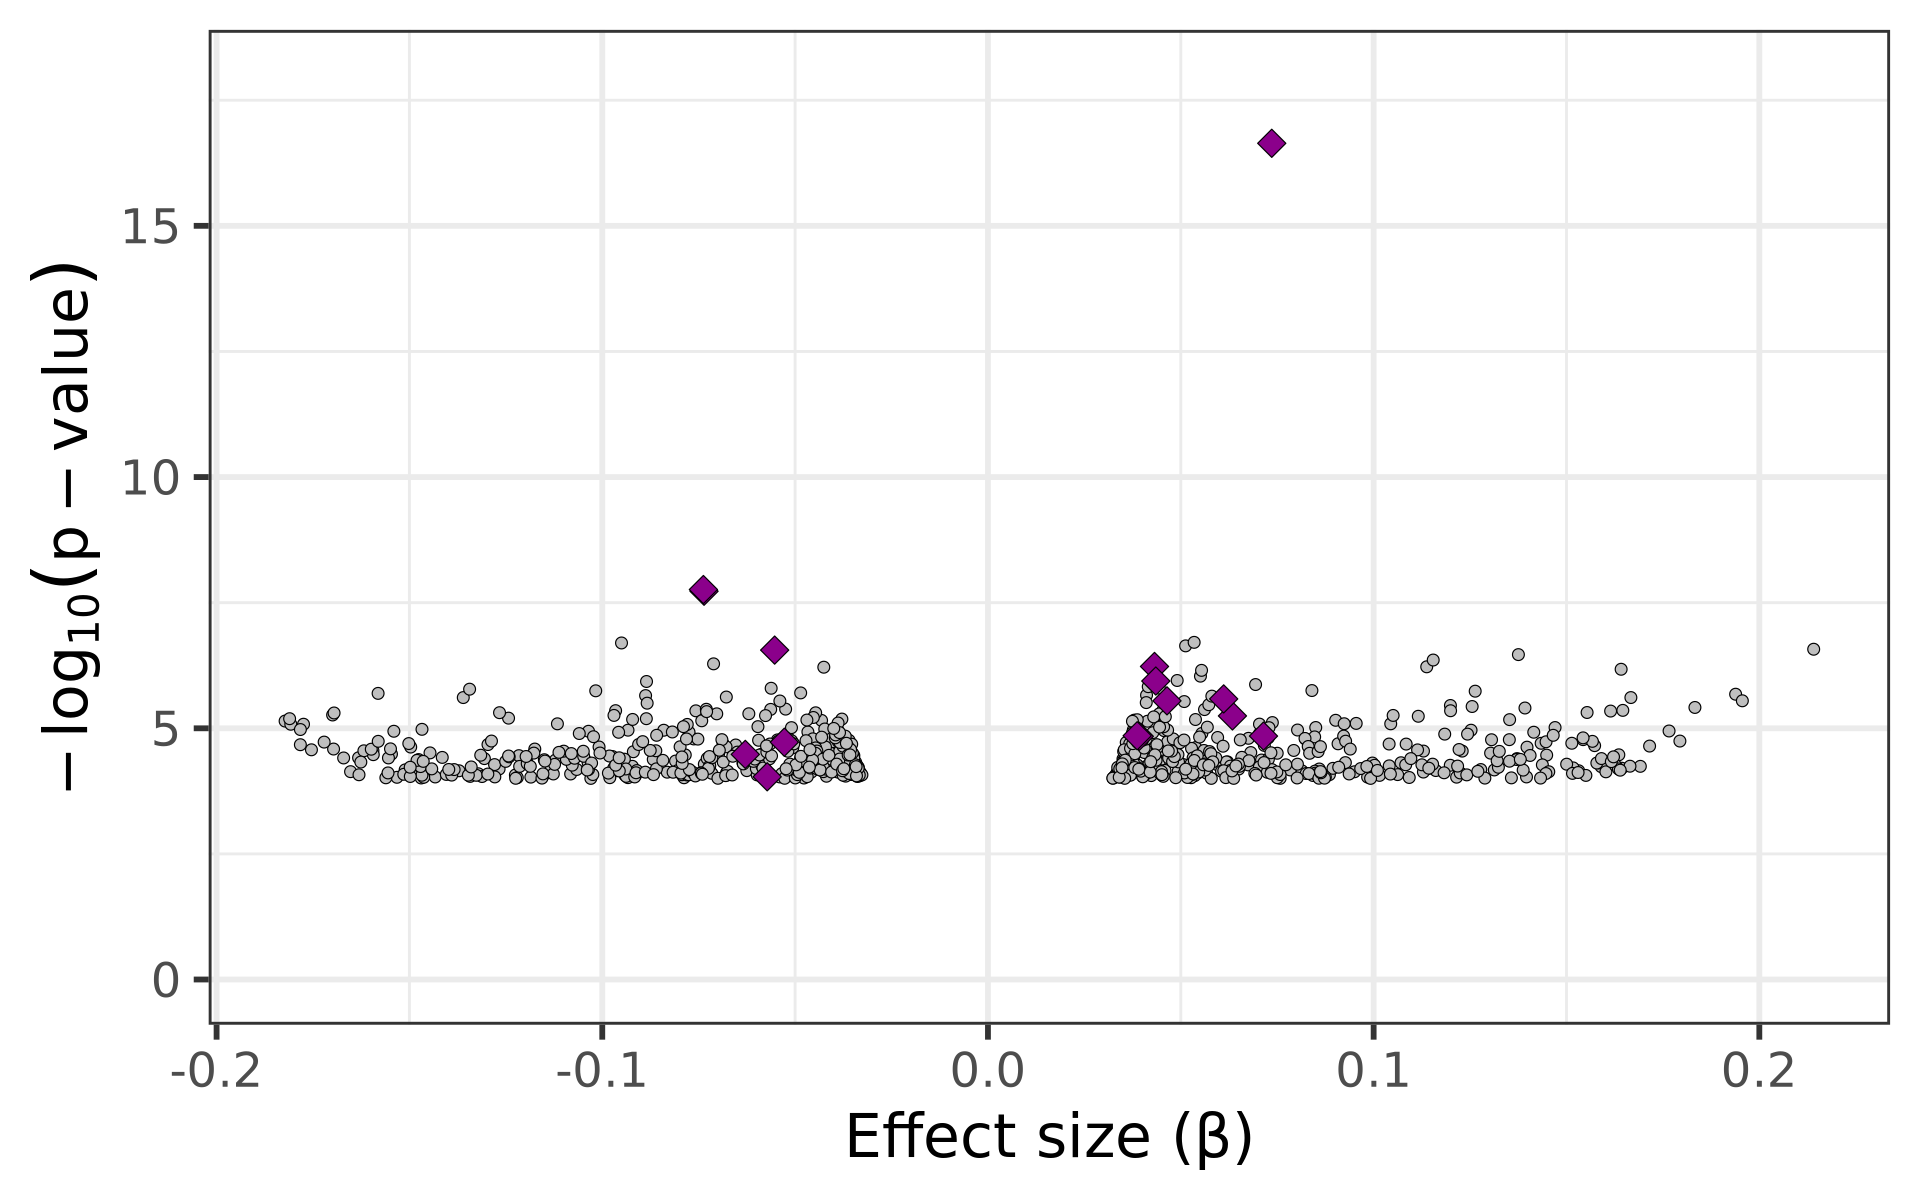

In [43]:
g = ggplot(merged_df_filtered %>% filter(Selected == "No"), aes(x=BETA, y = -log10(p.value))) + 
    geom_point(pch = 21, size = 3, fill = "grey75")+
    geom_point(data = merged_df_filtered %>% filter(Selected == "Yes"), 
               aes(x=BETA, y = -log10(p.value)), shape = 23, fill = "darkmagenta", size = 6)+
    labs(y = bquote(-log[10](p-value)), x = "Effect size (β)") +
    scale_y_continuous(limits = c(0,18))+
    theme_bw(base_size = 36)

g
ggsave(filename = "Data/Figures/Supplment/SNPsSelectedPGS.png", 
       plot = g, device = "png", 
       width = 16, height = 10, dpi = 300)

In [41]:
do_the_prs_walk = function(walking_step) {   
    #Write the variants for this walk.
    write.table(merged_df_filtered %>% 
                    head(walking_step) %>%
                    select(MarkerID), 
                file = "Data/Saige.V2/PGS/Liability/Walk/VariantsForWalk.txt",
               row.names = F, col.names = F, quote = F)

    #Write the summary stats file for the PRS walk.
    write.table(merged_df_filtered %>% 
                    head(walking_step) %>%
                    select(CHR,POS,Allele1,Allele2,BETA,p.value,MarkerID), 
                file = "Data/Saige.V2/PGS/Liability/Walk/SummaryStatsForWalk.txt",
               row.names = F, col.names = T, quote = F)

    #Write target file prefixes to be used by PRScise. 
    #Some chrs might not have any data so the standard # in PRScise command will not work
    write.table(paste0("Data/Saige.V2/PGS/Liability/Walk/extractedChr", merged_df_filtered %>% 
                    head(walking_step) %>%
                    pull(CHR) %>%
                    unique(), ".ForClumping"),
                file = "Data/Saige.V2/PGS/Liability/Walk/TargetFilePrefixes.txt",
               row.names = F, col.names = F, quote = F)

    #Loop over each chromosome to extract clumped loci of interest.
    for (chromosome in c(1:22)) {
        output_plink_subset_file = paste0("Data/Saige.V2/PGS/Liability/Walk/extractedChr", 
                                          chromosome, 
                                          ".ForClumping")
        #Extract regular plink file.
        plink_extract_command = paste("/usr/bin/plink2",
                               "--bfile",
                               paste0("Data/Saige.V2/PGS/Liability/ACAF/extractedChr", 
                                      chromosome, 
                                      ".ForClumping"), 
                               "--extract", 
                               "Data/Saige.V2/PGS/Liability/Walk/VariantsForWalk.txt",
                               "--make-bed",
                               "--out",
                               output_plink_subset_file,
                               sep = " ")

        s2 = system(plink_extract_command, intern = TRUE)
    }
    
    #Run PRScise for this walk.
    prscise_command = paste("Rscript ~/workspaces/admixturemapping/bin/PRSice/PRSice.R",
                        "--prsice ~/workspaces/admixturemapping/bin/PRSice/PRSice_linux",
                        "--base Data/Saige.V2/PGS/Liability/Walk/SummaryStatsForWalk.txt",
                        "--A1 Allele2",
                        "--A2 Allele1",
                        "--chr CHR",
                        "--bp POS",
                        "--stat BETA",
                        "--pvalue p.value",
                        "--snp MarkerID",
                        "--thread 12",
                        "--memory 97000",
                        "--beta",
                        "--binary-target F",
                        "--target-list Data/Saige.V2/PGS/Liability/Walk/TargetFilePrefixes.txt",
                        "--pheno Data/Saige.V2/CreatinineCohort.PhenotypeFile.PRSice.tsv",
                        "--pheno-col MedianCreatinine",
                        "--ignore-fid",
                        "--fastscore",
                        "--keep-ambig",
                        sep = " ")

    prs_command_output = system(prscise_command, intern = TRUE)
    
    #Move PRScise output.
    system(paste0("mv PRSice.best ", 
                 "Data/Saige.V2/PGS/Liability/Walk/Product/", 
                 "PRSciseResults.Walked",
                 walking_step,
                 "Loci.txt"), intern = TRUE)
    
    #Because no two runs should be the same even on accident.
    system(paste0("rm Data/Saige.V2/PGS/Liability/Walk/TargetFilePrefixes.txt"), intern = TRUE)
}

In [ ]:
mclapply(c(1:30), do_the_prs_walk, mc.cores = 1)

## PRS using fine mapping variants.

In [12]:
options(repr.plot.width=20, repr.plot.height=16)

rm(list=ls())
set.seed(13)

options(scipen=100, digits=3)

library('dplyr')
library('ggplot2')
library('data.table')
library('parallel')
library('stringr')
library('tidyr')

options(repr.plot.width=16, repr.plot.height=10)
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [13]:
# First read fine mapping results.
fine_mapping_variants = as.data.frame(fread("Data/FineMapping/SaigeGWAS/SaigeGWAS.FineMappingResults.txt")) %>% select(MarkerID)
dim(fine_mapping_variants)
head(fine_mapping_variants)

#Write for plink extraction.
write.table(fine_mapping_variants, 
            file = "Data/Saige.V2/PGS/Liability/Walk/FineMapping/SaigeGWAS.FineMappingResults.VariantIDs.txt", 
            sep = "\t", row.names = F, col.names = F, quote = F)

#Implement a read function.
fread_df = function(x) {
    return(as.data.frame(fread(x))) 
}

# Read GWAS results.
prepare_gwas_files = function(gwas_result_files) { 
    # Read and store the files in a list
    gwas_files_read = lapply(gwas_result_files, fread_df)

    # Combine the list of data frames into one data frame
    gwas_results = do.call(rbind, gwas_files_read)

    #Reset index.
    rownames(gwas_results) = NULL
    
    return(gwas_results)   
}

scr_gwas_results = prepare_gwas_files(paste0('Data/Saige.V2/Step2/extractedChr', 
                                                    c(1:22), 
                                                    '.SaigeGWAS')) %>%
                    filter(MarkerID %in% fine_mapping_variants$MarkerID)

dim(scr_gwas_results)
head(scr_gwas_results)

[1] 14  1

,MarkerID
,<chr>
1,chr15:45338576:A:T
2,chr15:45341646:G:A
3,chr15:45367576:T:A
4,chr15:45378483:A:C
5,chr15:45379909:C:T
6,chr15:45391250:CA:C


[1] 14 14

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,N
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,15,45338576,chr15:45338576:A:T,A,T,16615,0.438,0.0000000,0.0698,0.00860,943,13514,0.0000000000000005104,18979
2,15,45341646,chr15:45341646:G:A,G,A,16493,0.435,0.0000527,0.0698,0.00862,940,13462,0.0000000000000005531,18979
3,15,45367576,chr15:45367576:T:A,T,A,17930,0.472,0.0000000,0.0697,0.00862,938,13471,0.0000000000000006197,18979
4,15,45378483,chr15:45378483:A:C,A,C,16394,0.432,0.0367775,0.0720,0.00890,910,12638,0.0000000000000005912,18979
5,15,45379909,chr15:45379909:C:T,C,T,15707,0.414,0.0000527,0.0736,0.00868,977,13278,0.0000000000000000228,18979
6,15,45391250,chr15:45391250:CA:C,CA,C,15752,0.415,0.0090627,0.0726,0.00873,953,13124,0.0000000000000000863,18979


In [16]:
do_the_prs_walk = function(walking_step) {   
    #Write the variants for this walk.
    write.table(scr_gwas_results %>% 
                    head(walking_step) %>%
                    select(MarkerID), 
                file = "Data/Saige.V2/PGS/Liability/Walk/VariantsForWalk.txt",
               row.names = F, col.names = F, quote = F)

    #Write the summary stats file for the PRS walk.
    write.table(scr_gwas_results %>% 
                    head(walking_step) %>%
                    select(CHR,POS,Allele1,Allele2,BETA,p.value,MarkerID), 
                file = "Data/Saige.V2/PGS/Liability/Walk/SummaryStatsForWalk.txt",
               row.names = F, col.names = T, quote = F)

    #Write target file prefixes to be used by PRScise. 
    #Some chrs might not have any data so the standard # in PRScise command will not work
    #In this case, this will only output chr15.
    write.table(paste0("Data/Saige.V2/PGS/Liability/Walk/extractedChr", scr_gwas_results %>% 
                    head(walking_step) %>%
                    pull(CHR) %>%
                    unique(), ".ForClumping"),
                file = "Data/Saige.V2/PGS/Liability/Walk/TargetFilePrefixes.txt",
               row.names = F, col.names = F, quote = F)

    #Subset chr15
    #Loop over each chromosome to extract clumped loci of interest.
    output_plink_subset_file = paste0("Data/Saige.V2/PGS/Liability/Walk/extractedChr15.ForClumping")
   
    #Extract regular plink file.
    plink_extract_command = paste("/usr/bin/plink2",
                           "--bfile",
                           "Data/Saige.V2/ACAF/extractedChr15.ACAF.QC.PlinkNative", 
                           "--extract", 
                           "Data/Saige.V2/PGS/Liability/Walk/VariantsForWalk.txt",
                           "--make-bed",
                           "--out",
                           output_plink_subset_file,
                           sep = " ")

    s2 = system(plink_extract_command, intern = TRUE)
    
    #Run PRScise for this walk.
    prscise_command = paste("Rscript ~/workspaces/admixturemapping/bin/PRSice/PRSice.R",
                        "--prsice ~/workspaces/admixturemapping/bin/PRSice/PRSice_linux",
                        "--base Data/Saige.V2/PGS/Liability/Walk/SummaryStatsForWalk.txt",
                        "--A1 Allele2",
                        "--A2 Allele1",
                        "--chr CHR",
                        "--bp POS",
                        "--stat BETA",
                        "--pvalue p.value",
                        "--snp MarkerID",
                        "--thread 12",
                        "--memory 97000",
                        "--beta",
                        "--binary-target F",
                        "--no-clump",
                        "--target-list Data/Saige.V2/PGS/Liability/Walk/TargetFilePrefixes.txt",
                        "--pheno Data/Saige.V2/CreatinineCohort.PhenotypeFile.PRSice.tsv",
                        "--pheno-col MedianCreatinine",
                        "--ignore-fid",
                        "--fastscore",
                        "--keep-ambig",
                        sep = " ")

    prs_command_output = system(prscise_command, intern = TRUE)
    
    #Move PRScise output.
    system(paste0("mv PRSice.best ", 
                 "Data/Saige.V2/PGS/Liability/Walk/FineMapping/", 
                 "PRSciseResults.Walked",
                 walking_step,
                 "Loci.txt"), intern = TRUE)
    
    #Because no two runs should be the same even on accident.
    system(paste0("rm Data/Saige.V2/PGS/Liability/Walk/TargetFilePrefixes.txt"), intern = TRUE)
}

In [17]:
mclapply(c(1:14), do_the_prs_walk, mc.cores = 1)

[[1]]
character(0)

[[2]]
character(0)

[[3]]
character(0)

[[4]]
character(0)

[[5]]
character(0)

[[6]]
character(0)

[[7]]
character(0)

[[8]]
character(0)

[[9]]
character(0)

[[10]]
character(0)

[[11]]
character(0)

[[12]]
character(0)

[[13]]
character(0)

[[14]]
character(0)